In [2]:
import torch
import torchvision.transforms as transforms
import timm
from tqdm import tqdm
from torch.utils.data import Dataset, Subset, DataLoader, Sampler
import glob
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
import json
import math

os.environ["LOKY_MAX_CPU_COUNT"] = "6"

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.__version__)

2.6.0+cu126


Andesite  :	43802
Basalt    :	26810
Etc       :	15935
Gneiss    :	73914
Granite   :	92923
Mud_Sandstone:	89467
Weathered_Rock:	37169


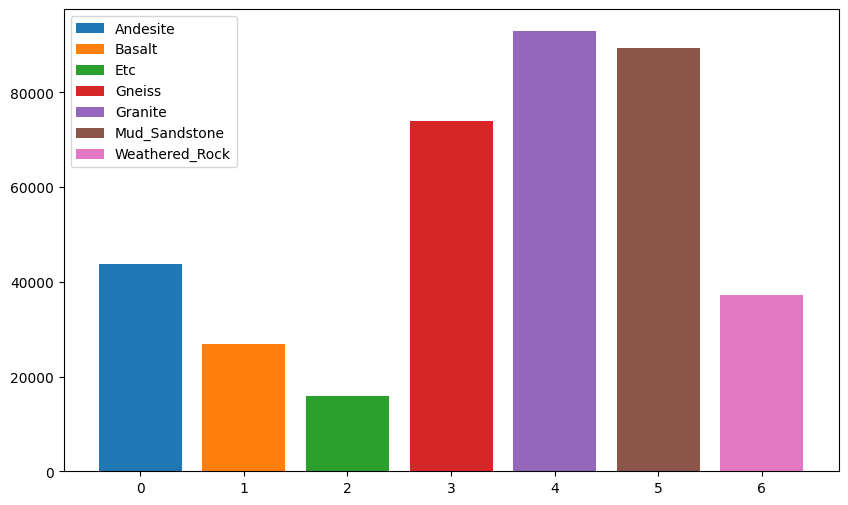

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for index, folder_name in enumerate(glob.glob(r'C:\Users\user\Downloads\open\open\train\*')):
    plt.bar(index, len(glob.glob(f'{folder_name}\\*')), label=os.path.basename(folder_name))
    print(f"{os.path.basename(folder_name):<10s}:\t{len(glob.glob(f'{folder_name}\\*'))}")

plt.legend()
plt.show()

In [6]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.epoch = 60

        self.image_size = (224, 224)
        self.lr = 0.00005
        self.weight_decay = 0.001
    
        self.train_data_dir = r'C:\Users\user\Downloads\open\open\train'
        self.test_data_dir = r'C:\Users\user\Downloads\open\open\test'
        self.test_size = 0.2
        self.batch_size = 36
        self.sample_num = 8000

        self.visualize_epoch = 5
        self.visualize_save_dir = os.path.join(os.getcwd(), 'visualized_features')

config = Config()

In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, z_i, z_j, z_label=None):
        batch_size = z_i.size(0)
        
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        
        sim_matrix = torch.matmul(z, z.T) / self.temperature
        sim_matrix = sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0]

        labels = z_label.repeat_interleave(2)
        mask = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float().to(z_i.device)
        mask.fill_diagonal_(0)

        logits_mask = ~torch.eye(2 * batch_size, dtype=torch.bool).to(z_i.device)
        exp_sim = torch.exp(sim_matrix) * logits_mask

        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-12)
        log_prob = log_prob * logits_mask

        loss = -(mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-12)
        # loss = -loss.mean()

        return loss

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        targets = targets.view(-1, 1)

        log_p = log_probs.gather(1, targets).squeeze(1)
        p_t = probs.gather(1, targets).squeeze(1)

        if self.alpha is not None:
            if isinstance(self.alpha, (list, torch.Tensor)):
                alpha_t = self.alpha[targets.squeeze()]
            else:
                alpha_t = self.alpha
            loss = -alpha_t * (1 - p_t) ** self.gamma * log_p
        else:
            loss = -(1 - p_t) ** self.gamma * log_p

        return loss

In [10]:
class StratifiedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size

        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

        self.class_ratios = {
            label: len(idxs) / len(self.labels)
            for label, idxs in self.label_to_indices.items()
        }

        self.label_queues = {
            label: [] for label in self.label_to_indices
        }

        self._reset_label_queues()
        self.batches = self._create_batches()

    def _reset_label_queues(self):
        for label in self.label_to_indices:
            indices = self.label_to_indices[label]
            random.shuffle(indices)
            self.label_queues[label].extend(indices)

    def _create_batches(self):
        batches = []
        current_batch = []

        total_samples = len(self.labels)
        num_batches = math.ceil(total_samples / self.batch_size)

        for _ in range(num_batches):
            batch = []
            for label, ratio in self.class_ratios.items():
                n_samples = int(round(ratio * self.batch_size))

                # refill if empty
                if len(self.label_queues[label]) < n_samples:
                    remaining = self.label_to_indices[label][:]
                    random.shuffle(remaining)
                    self.label_queues[label].extend(remaining)

                for _ in range(n_samples):
                    if self.label_queues[label]:
                        batch.append(self.label_queues[label].pop())

            # 보정: 너무 작거나 클 경우
            if len(batch) > self.batch_size:
                batch = random.sample(batch, self.batch_size)
                
            elif len(batch) < self.batch_size:
                # 부족하면 다른 클래스에서 추가
                extra = self.batch_size - len(batch)
                flat_pool = sum(self.label_queues.values(), [])
                random.shuffle(flat_pool)
                batch += flat_pool[:extra]
                for idx in batch[-extra:]:
                    label = self.labels[idx]
                    if idx in self.label_queues[label]:
                        self.label_queues[label].remove(idx)

            batches.append(batch)

        return batches

    def __iter__(self):
        random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [21]:
class custom_model(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()

        if isinstance(backbone, str):
            self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)
        elif isinstance(backbone, nn.Module):
            self.backbone = backbone
        else:
            raise

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            num_features = self.backbone(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(num_features, 2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 256),
            nn.GELU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_features=False):
        features = self.backbone(x)

        if return_features:
            return self.head(features), features
        
        return self.head(features)
    
    def forward_features(self, x):
        return self.backbone(x)

In [11]:
item_list = glob.glob(rf"{config.train_data_dir}\*\*")
len(item_list)

380020

In [12]:
_num_classes = len(glob.glob(rf"{config.train_data_dir}\*"))
_num_classes

7

In [12]:
# _backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
_backbone = torch.load('backbone.pt', weights_only=False, map_location='cpu')

model = custom_model(_backbone, _num_classes).to(config.device)
model

custom_model(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='non

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.41427545, 0.40396059, 0.39235218], 
                         std=[0.17746354, 0.17282704, 0.16986775])
])

valid_transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.41427545, 0.40396059, 0.39235218], 
                         std=[0.17746354, 0.17282704, 0.16986775])
])

In [14]:
class custom_dataset(Dataset):
    def __init__(self, image_path_set, label_list, transform):
        # self.image_paths = [path for path, label in image_path_set]
        # self.labels = [label for path, label in image_path_set]
        self.image_paths = [path for path in image_path_set]
        self.labels = [os.path.basename(os.path.dirname(path)) for path in image_path_set]

        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        _image_path = self.image_paths[index]
        _image_label = self.label_list.index(self.labels[index])

        _image = Image.open(_image_path)
        _image_1 = self.transform(_image)
        _image_2 = self.transform(_image)

        return (_image_1, _image_2), _image_label, _image_path

In [15]:
class custom_data_factory():
    def __init__(self, paths, sample_num, train_transform, valid_transform):
        # self.paths = [(path, os.path.basename(os.path.dirname(path))) for path in paths]
        self.path_dict = {}
        for path in paths:
            _class = os.path.basename(os.path.dirname(path))
            if self.path_dict.get(_class) == None:
                self.path_dict[_class] = []

            self.path_dict[_class].append(path)

        self.selected_items = {_label: random.choices(_path_list, k=min(len(_path_list), sample_num)) for _label, _path_list in self.path_dict.items()}

        self.label_list = list(self.path_dict.keys())

        self.sample_num = sample_num
        self.train_transform = train_transform
        self.valid_transform = valid_transform

        self.losses = []

    def get_data_set(self):
        _item_list =  sum(self.selected_items.values(), [])
        random.shuffle(_item_list)

        train_index_set, valid_index_set = train_test_split(
            _item_list,
            test_size=config.test_size,
            stratify=sum([[_label] * len(_path_list) for _label, _path_list in self.selected_items.items()], []),
            shuffle=True,
            random_state=42
        )
        
        self.train_set = custom_dataset(train_index_set, self.label_list, self.train_transform)
        self.valid_set = custom_dataset(valid_index_set, self.label_list, self.valid_transform)

        print(f'Train set: {Counter(self.train_set.labels)}')
        print(f'Valid set: {Counter(self.valid_set.labels)}')

        return self.train_set, self.valid_set
    
    def get_data_loader(self):
        train_loader = DataLoader(
            self.train_set, pin_memory=True, 
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.train_set.labels], 
                batch_size=config.batch_size
            )
        )

        valid_loader = DataLoader(
            self.valid_set, pin_memory=True,
            batch_sampler=StratifiedBatchSampler(
                [self.label_list.index(_label) for _label in self.valid_set.labels], 
                batch_size=config.batch_size
            )
        )

        return train_loader, valid_loader
    
    def collect_losses(self, _paths, _labels, _losses):
        for _path, _label, _loss in zip(_paths, _labels, _losses):
            self.losses.append((_path, _label.item(), _loss.item()))

    def renew_data_loader(self, resample_ratio):
        selected_items_dict = {}
        for _path, _label, _loss in self.losses:
            _label = self.label_list[_label]
            if selected_items_dict.get(_label) == None:
                selected_items_dict[_label] = []

            selected_items_dict[_label].append((_path, _loss))
        
        selected_items = {}
        for _label, _path_list in selected_items_dict.items():
            _paths, _weights = zip(*_path_list)
            _weights = [(_weight - min(_weights))/(max(_weights)-min(_weights)) for _weight in _weights]

            selected_items[_label] = random.choices(_paths,
                                                    k=int(self.sample_num * (1-resample_ratio)),
                                                    weights=_weights)
        
        unselected_items = {_label: random.sample([_path for _path in _path_list if _path not in selected_items_dict[_label]],
                                                  k=int(self.sample_num * resample_ratio)) for _label, _path_list in self.path_dict.items()}

        self.selected_items = {}
        for (_label, _selected_path_list), (_label, _unselected_path_list) in zip(selected_items.items(), unselected_items.items()):
            self.selected_items[_label] = []
            self.selected_items[_label].extend(_selected_path_list)
            # print(f'{_label}-selected: {len(_selected_path_list)}')
            self.selected_items[_label].extend(_unselected_path_list)
            # print(f'{_label}-unselected: {len(_unselected_path_list)}')
            # print()

        self.losses = []

        self.get_data_set()

        return self.get_data_loader()

In [16]:
data_factory = custom_data_factory(item_list, config.sample_num, train_transform, valid_transform)

In [17]:
data_factory.label_list

['Andesite',
 'Basalt',
 'Etc',
 'Gneiss',
 'Granite',
 'Mud_Sandstone',
 'Weathered_Rock']

In [18]:
for label, selected_items in data_factory.selected_items.items():
    print(f'{label}: {len(selected_items)}')

Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000


In [19]:
# paths = [(path, os.path.basename(os.path.dirname(path))) for path in item_list]
# _, labels = zip(*paths)

# train_index_set, valid_index_set = train_test_split(
#     paths,
#     test_size=config.test_size,
#     stratify=labels,
#     shuffle=True,
#     random_state=42
# )

In [20]:
# label_list = list(set(labels))

In [21]:
# train_set = custom_dataset(train_index_set, label_list, train_transform)
# valid_set = custom_dataset(valid_index_set, label_list, valid_transform)

In [22]:
# print(len(train_set))
# print(len(valid_set))

In [23]:
# train_loader = DataLoader(
#     train_set, pin_memory=True, 
#     batch_sampler=StratifiedBatchSampler(
#         [label_list.index(_label) for _label in train_set.labels], 
#         batch_size=config.batch_size
#     )
# )

# valid_loader = DataLoader(
#     valid_set, pin_memory=True,
#     batch_sampler=StratifiedBatchSampler(
#         [label_list.index(_label) for _label in valid_set.labels], 
#         batch_size=config.batch_size
#     )
# )

In [24]:
# print(len(train_loader))
# print(len(valid_loader))

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=config.epoch//3,
    T_mult=3,
    eta_min=config.lr / 10
    )

In [28]:
def visualize_features(features_dict, epoch):
    os.makedirs(config.visualize_save_dir, exist_ok=True)

    all_features = np.concatenate([np.array(value) for label_name, value in features_dict.items()], axis=0)
    labels = sum([[label_name] * len(value) for label_name, value in features_dict.items()], [])
    
    n_samples = len(all_features)
    perplexity = min(30, n_samples - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_2d = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], 
                    hue=labels)
    
    plt.title(f'Feature Space Visualization (t-SNE)\nSamples: {n_samples}, Perplexity: {perplexity}')
    plt.savefig(os.path.join(config.visualize_save_dir, f'feature_space_{epoch}.png'))
    plt.close()
    
    print("Visualization completed successfully")
        

In [29]:
def evaluate(model, epoch, valid_loader):
    model.eval()
    all_probs, all_labels = [], []
    features_dict = {label:[] for label in data_factory.label_list}
    
    with torch.no_grad():
        for images, labels, paths in tqdm(valid_loader, desc=f'Validating', leave=False):
            images, labels = images[0].to(config.device), labels.to(config.device)
            
            outputs, features = model(images, return_features=True)

            probs = F.softmax(outputs, dim=1)

            features_np = features.cpu().numpy()
            labels_np = labels.cpu().numpy()

            for feat, label in zip(features_np, labels_np):
                features_dict[data_factory.label_list[label]].append(feat)

            all_probs.append(probs.cpu().numpy().flatten())
            all_labels.append(labels_np)
    
    if epoch % config.visualize_epoch == 0:
        visualize_features(features_dict, epoch)
        
    all_probs_roc = np.array(all_probs).reshape(-1, len(data_factory.label_list))
    all_probs = np.array([np.argmax(_pred) for _pred in all_probs_roc])
    all_labels = np.array(all_labels).flatten()

    return {
        'accuracy': accuracy_score(all_labels, all_probs),
        'precision': precision_score(all_labels, all_probs, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_probs, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_probs, average='weighted', zero_division=0),
        'roc_auc':roc_auc_score(all_labels, all_probs_roc, multi_class='ovr'),
        'confusion_matrix': confusion_matrix(all_labels, all_probs)
    }

In [30]:
def train(model, start_epoch=0):
    train_history = {}

    contrastive_criterion = NTXentLoss()
    normal_criterion = FocalLoss()

    best_score = -1.0

    data_factory.get_data_set()
    train_loader, valid_loader = data_factory.get_data_loader()

    for epoch in range(config.epoch):
        if epoch < start_epoch:
            continue

        model.train()
        total_losses = 0.0
        
        if epoch < config.epoch // 3:
            for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}'):
                image_1, image_2 = images[0].to(config.device), images[1].to(config.device)
                labels = labels.to(config.device)

                optimizer.zero_grad()
                
                z_1 = model.forward_features(image_1)
                z_2 = model.forward_features(image_2)

                loss = contrastive_criterion(z_1, z_2, labels)
                
                loss.mean().backward()
                optimizer.step()

                total_losses += loss.mean().item()
                scheduler.step()

                data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        else:
            if epoch < config.epoch // 3 + 7:
                for param in model.backbone.parameters():
                    param.requires_grad = False

            for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}', leave=False):
                images = images[0].to(config.device)
                labels = labels.to(config.device)

                optimizer.zero_grad()
                
                outputs = model(images)
                
                loss = normal_criterion(outputs, labels)
                
                loss.mean().backward()
                optimizer.step()

                total_losses += loss.mean().item()
                scheduler.step()
                
                data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        valid_results = evaluate(model, epoch, valid_loader=valid_loader)
        if best_score < valid_results['f1']:
            best_score = valid_results['f1']
            torch.save(model, 'best_model.pt')

        print(f"epoch {epoch+1:>3d}", end='/')
        print(f"accuracy: {valid_results['accuracy']}", end=' / ')
        print(f"precision: {valid_results['precision']}", end=' / ')
        print(f"recall: {valid_results['recall']}", end=' / ')
        print(f"f1: {valid_results['f1']}", end=' / ')
        print(f"roc_auc: {valid_results['roc_auc']}")
        print(f"{valid_results['confusion_matrix']}")

        train_history[epoch] = valid_results

        print("renew data_loader") 
        train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.7)
        for label, selected_items in data_factory.selected_items.items():
            print(f'{label}: {len(selected_items)}', end='\n')
        print()
        
    with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
        json.dump(train_history, json_file, indent=2, ensure_ascii=False)

In [31]:
def train_noSSL(model):
    train_history = {}

    contrastive_criterion = NTXentLoss()
    normal_criterion = FocalLoss()

    best_score = -1.0

    data_factory.get_data_set()
    train_loader, valid_loader = data_factory.get_data_loader()

    for epoch in range(config.epoch):
        model.train()
        total_losses = 0.0
        
        for images, labels, paths in tqdm(train_loader, desc=f'Training epoch: {epoch+1}/{config.epoch}', leave=False):
            images = images[0].to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = normal_criterion(outputs, labels)
            
            loss.mean().backward()
            optimizer.step()

            total_losses += loss.mean().item()
            scheduler.step()
            
            data_factory.collect_losses(paths, labels.cpu(), loss.cpu())

        valid_results = evaluate(model, epoch, valid_loader=valid_loader)
        if best_score < valid_results['f1']:
            best_score = valid_results['f1']
            torch.save(model, 'best_model.pt')

        print(f"epoch {epoch+1:>3d}", end='/')
        print(f"accuracy: {valid_results['accuracy']}", end=' / ')
        print(f"precision: {valid_results['precision']}", end=' / ')
        print(f"recall: {valid_results['recall']}", end=' / ')
        print(f"f1: {valid_results['f1']}", end=' / ')
        print(f"roc_auc: {valid_results['roc_auc']}")
        print(f"{valid_results['confusion_matrix']}")

        train_history[epoch] = valid_results

        print("renew data_loader")
        train_loader, valid_loader = data_factory.renew_data_loader(resample_ratio=0.7)
        for label, selected_items in data_factory.selected_items.items():
            print(f'{label}: {len(selected_items)}', end='\n')
        print()
        
    with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
        json.dump(train_history, json_file, indent=2, ensure_ascii=False)

In [32]:
# model.load_state_dict(torch.load('best_model.pt', weights_only=True))
# model = torch.load('best_model.pt', weights_only=False)
model = model.to(config.device)

train_noSSL(model)

Train set: Counter({'Weathered_Rock': 6482, 'Andesite': 6471, 'Gneiss': 6399, 'Mud_Sandstone': 6389, 'Granite': 6366, 'Basalt': 6360, 'Etc': 6333})
Valid set: Counter({'Etc': 1667, 'Basalt': 1640, 'Granite': 1634, 'Mud_Sandstone': 1611, 'Gneiss': 1601, 'Andesite': 1529, 'Weathered_Rock': 1518})


Visualization completed successfully
epoch   1/accuracy: 0.7873931623931624 / precision: 0.7885826592799051 / recall: 0.7873931623931624 / f1: 0.7852782434986464 / roc_auc: 0.9593567992843822
[[1414   25   26   21    2   88   34]
 [  10 1546    0    1    0   36    7]
 [ 223   16  897  128   46  147  158]
 [  83   27  212 1137   31   52   63]
 [  17    0   97   34 1386    6   62]
 [ 184   34   66   89    0 1168   63]
 [ 104   20   92   24   31   29 1296]]
renew data_loader
Train set: Counter({'Etc': 6465, 'Granite': 6451, 'Andesite': 6401, 'Mud_Sandstone': 6395, 'Weathered_Rock': 6391, 'Gneiss': 6367, 'Basalt': 6330})
Valid set: Counter({'Basalt': 1670, 'Gneiss': 1633, 'Weathered_Rock': 1609, 'Mud_Sandstone': 1605, 'Andesite': 1599, 'Granite': 1549, 'Etc': 1535})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   2/accuracy: 0.6975605413105413 / precision: 0.6954868924877596 / recall: 0.6975605413105413 / f1: 0.6958003384251926 / roc_auc: 0.9365500656737896
[[1166   21  116   48   10  175   69]
 [  15 1488    2    2    0   86   14]
 [ 105   22  741  283  112  152  181]
 [  51   22  148 1107   82  144   56]
 [  25    0   87  130 1283   19   65]
 [ 151   29  166  104    8 1026  116]
 [ 133   51  122  103  104   68 1024]]
renew data_loader
Train set: Counter({'Gneiss': 6428, 'Andesite': 6426, 'Basalt': 6414, 'Mud_Sandstone': 6397, 'Etc': 6393, 'Weathered_Rock': 6371, 'Granite': 6371})
Valid set: Counter({'Granite': 1629, 'Weathered_Rock': 1629, 'Etc': 1607, 'Mud_Sandstone': 1603, 'Basalt': 1586, 'Andesite': 1574, 'Gneiss': 1572})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   3/accuracy: 0.7097578347578347 / precision: 0.7082377367521091 / recall: 0.7097578347578347 / f1: 0.7036733095323213 / roc_auc: 0.9420711564626184
[[1132   36   70   76   30  213   52]
 [   1 1474    0    3    2   50   70]
 [  83   45  704  264  227  176  110]
 [  34   19  165 1129  143   61   53]
 [   7    0   15   75 1494    1   18]
 [ 116   70  105  173   27 1045   65]
 [  85   17  121  139  191   52  994]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6474, 'Etc': 6448, 'Gneiss': 6424, 'Basalt': 6399, 'Mud_Sandstone': 6395, 'Andesite': 6373, 'Granite': 6287})
Valid set: Counter({'Granite': 1713, 'Andesite': 1627, 'Mud_Sandstone': 1605, 'Basalt': 1601, 'Gneiss': 1576, 'Etc': 1552, 'Weathered_Rock': 1526})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   4/accuracy: 0.7713675213675214 / precision: 0.7758642090396195 / recall: 0.7713675213675214 / f1: 0.7710103418598531 / roc_auc: 0.9619694632185585
[[1321    3   42   53    4   75   62]
 [  20 1476    4    2    7   40   11]
 [  94   13  871  261   67  101  153]
 [  54    9  127 1218   48   25   79]
 [  12    1   96  114 1534    6  109]
 [ 165    8   96  152    8 1041   90]
 [  37   27  137   78   49   29 1203]]
renew data_loader
Train set: Counter({'Basalt': 6454, 'Granite': 6453, 'Mud_Sandstone': 6424, 'Etc': 6417, 'Andesite': 6370, 'Weathered_Rock': 6349, 'Gneiss': 6333})
Valid set: Counter({'Gneiss': 1667, 'Weathered_Rock': 1651, 'Andesite': 1630, 'Etc': 1583, 'Mud_Sandstone': 1576, 'Granite': 1547, 'Basalt': 1546})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   5/accuracy: 0.8053774928774928 / precision: 0.8034778013339232 / recall: 0.8053774928774928 / f1: 0.8028544602620203 / roc_auc: 0.9719856360759925
[[1414    6   45   22    7   45   76]
 [  10 1589    0    0    0    9    2]
 [  67   10  981  197  113   77  147]
 [  30    1  148 1235   93   37   61]
 [   6    1   44   17 1465    2   66]
 [ 167   22   89   98   11 1133   76]
 [  43   39  118   55   80   49 1229]]
renew data_loader
Train set: Counter({'Granite': 6449, 'Basalt': 6427, 'Gneiss': 6424, 'Andesite': 6406, 'Etc': 6391, 'Mud_Sandstone': 6372, 'Weathered_Rock': 6331})
Valid set: Counter({'Weathered_Rock': 1669, 'Mud_Sandstone': 1628, 'Etc': 1609, 'Andesite': 1594, 'Gneiss': 1576, 'Basalt': 1573, 'Granite': 1551})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch   6/accuracy: 0.7138532763532763 / precision: 0.7162829570735184 / recall: 0.7138532763532763 / f1: 0.711111524792493 / roc_auc: 0.948270832667386
[[1154    7   35   79    9  188  133]
 [   8 1500    1   24    0   63    4]
 [ 108   18  660  262   90  123  341]
 [  32    7  171 1140   48  113   83]
 [  35    1   90  110 1259    9  109]
 [ 134   16  113  121   10 1080  136]
 [  53   48   81  104   71   26 1225]]
renew data_loader
Train set: Counter({'Basalt': 6458, 'Etc': 6423, 'Weathered_Rock': 6412, 'Gneiss': 6401, 'Andesite': 6398, 'Mud_Sandstone': 6388, 'Granite': 6320})
Valid set: Counter({'Granite': 1680, 'Mud_Sandstone': 1612, 'Andesite': 1602, 'Gneiss': 1599, 'Weathered_Rock': 1588, 'Etc': 1577, 'Basalt': 1542})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   7/accuracy: 0.7456374643874644 / precision: 0.7504412977095642 / recall: 0.7456374643874644 / f1: 0.7453010262567796 / roc_auc: 0.9554422023575115
[[1198   22  161   20   19  119   61]
 [   1 1577    1    2    1    5   15]
 [  39   12 1015  189  128  121   92]
 [  31   13  281 1078   98   61   48]
 [  10    0   80   78 1406    3   29]
 [ 115   57  116  137    6 1102   74]
 [  51   39  237  105  146   34  999]]
renew data_loader
Train set: Counter({'Etc': 6493, 'Granite': 6431, 'Basalt': 6403, 'Weathered_Rock': 6400, 'Mud_Sandstone': 6376, 'Andesite': 6372, 'Gneiss': 6325})
Valid set: Counter({'Gneiss': 1675, 'Andesite': 1628, 'Mud_Sandstone': 1624, 'Weathered_Rock': 1600, 'Basalt': 1597, 'Granite': 1569, 'Etc': 1507})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   8/accuracy: 0.7619301994301995 / precision: 0.7637451071405759 / recall: 0.7619301994301995 / f1: 0.7600860718572572 / roc_auc: 0.9607094848325571
[[1340   22   66   10    8  135   28]
 [   5 1550    1    2    0   32    9]
 [  73   28 1047   94  121  148   94]
 [  53    7  321  973   72  101   89]
 [  13    0   75   45 1391   19   54]
 [ 153   31   80   87    5 1179   58]
 [  81   27  169   39  138   81 1078]]
renew data_loader
Train set: Counter({'Andesite': 6466, 'Basalt': 6466, 'Weathered_Rock': 6421, 'Gneiss': 6416, 'Mud_Sandstone': 6354, 'Granite': 6349, 'Etc': 6328})
Valid set: Counter({'Etc': 1672, 'Granite': 1651, 'Mud_Sandstone': 1646, 'Gneiss': 1584, 'Weathered_Rock': 1579, 'Basalt': 1534, 'Andesite': 1534})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch   9/accuracy: 0.7894408831908832 / precision: 0.7926606844759094 / recall: 0.7894408831908832 / f1: 0.7903017465408004 / roc_auc: 0.9683607612194255
[[1298   20   61   37   18  124   47]
 [   1 1568    1    0    0   12   21]
 [  46   11 1123  167  105   63   99]
 [  27    3  270 1108   55   74   70]
 [   7    0   63   76 1342    0  116]
 [  86   30  132  103   12 1178   61]
 [  42   17  174   36   29   49 1250]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6468, 'Gneiss': 6428, 'Basalt': 6422, 'Granite': 6415, 'Mud_Sandstone': 6360, 'Etc': 6354, 'Andesite': 6353})
Valid set: Counter({'Andesite': 1647, 'Etc': 1646, 'Mud_Sandstone': 1640, 'Granite': 1585, 'Basalt': 1578, 'Gneiss': 1572, 'Weathered_Rock': 1532})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  10/accuracy: 0.7987001424501424 / precision: 0.7959257576097911 / recall: 0.7987001424501424 / f1: 0.7968621940309076 / roc_auc: 0.9719787918357928
[[1371   29   34   30    4   94   52]
 [   3 1580   10    7    1    4    2]
 [  56    5 1055  146   93   94  166]
 [  23    3  197 1130   71   82   86]
 [   8    1   56   20 1424   24   59]
 [ 131   42   86   92    0 1211   48]
 [  54   41   95   56   96   60 1200]]
renew data_loader
Train set: Counter({'Gneiss': 6431, 'Basalt': 6422, 'Etc': 6413, 'Weathered_Rock': 6409, 'Mud_Sandstone': 6393, 'Andesite': 6383, 'Granite': 6349})
Valid set: Counter({'Granite': 1651, 'Andesite': 1617, 'Mud_Sandstone': 1607, 'Weathered_Rock': 1591, 'Etc': 1587, 'Basalt': 1578, 'Gneiss': 1569})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  11/accuracy: 0.812232905982906 / precision: 0.8171723045928849 / recall: 0.812232905982906 / f1: 0.8113224777777749 / roc_auc: 0.9782590932239218
[[1345    4   75   16    1   62   96]
 [   3 1565    1    0    0   32    9]
 [  21    8 1245   81   99   42  112]
 [   7    7  215 1157   76   58   81]
 [   5    0   38   24 1437    2   97]
 [ 193   18  168   95    6 1020  106]
 [  15   39  113   36   29   19 1354]]
renew data_loader
Train set: Counter({'Basalt': 6416, 'Granite': 6413, 'Weathered_Rock': 6408, 'Andesite': 6400, 'Mud_Sandstone': 6393, 'Etc': 6387, 'Gneiss': 6383})
Valid set: Counter({'Gneiss': 1617, 'Etc': 1613, 'Mud_Sandstone': 1607, 'Andesite': 1600, 'Weathered_Rock': 1592, 'Granite': 1587, 'Basalt': 1584})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  12/accuracy: 0.833511396011396 / precision: 0.8359593003245133 / recall: 0.833511396011396 / f1: 0.833264756737523 / roc_auc: 0.9820781347754618
[[1352    2   58   18    5  112   56]
 [   6 1559    0   16    1    4    9]
 [  20   13 1145  156   68   25  179]
 [  25    1  135 1299   45   39   63]
 [   8    1   26   43 1448    2   79]
 [  91   18  128   94    4 1178  101]
 [  19   28   63   40   39   30 1381]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6421, 'Granite': 6416, 'Gneiss': 6413, 'Mud_Sandstone': 6406, 'Etc': 6385, 'Basalt': 6382, 'Andesite': 6377})
Valid set: Counter({'Andesite': 1623, 'Basalt': 1618, 'Etc': 1615, 'Mud_Sandstone': 1594, 'Gneiss': 1587, 'Granite': 1584, 'Weathered_Rock': 1579})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  13/accuracy: 0.8613782051282052 / precision: 0.8618876870420994 / recall: 0.8613782051282052 / f1: 0.8611828255332766 / roc_auc: 0.985522897165862
[[1393    3   27   12   14  112   48]
 [   3 1587    2    1    0   13    4]
 [  21    5 1206  137   84   74   75]
 [   7    6  148 1342   30   55   15]
 [   1    0   27   62 1453    8   51]
 [  65   12   47   41    4 1406   31]
 [  14   29  105   69   51   44 1288]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6415, 'Gneiss': 6414, 'Mud_Sandstone': 6410, 'Etc': 6406, 'Basalt': 6397, 'Granite': 6397, 'Andesite': 6361})
Valid set: Counter({'Andesite': 1639, 'Basalt': 1603, 'Granite': 1603, 'Etc': 1594, 'Mud_Sandstone': 1590, 'Gneiss': 1586, 'Weathered_Rock': 1585})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  14/accuracy: 0.8757122507122507 / precision: 0.8771984203711499 / recall: 0.8757122507122507 / f1: 0.87579880064724 / roc_auc: 0.9883252266153202
[[1400    7   43   21    1   90   35]
 [   1 1594    1    1    0    2    8]
 [   8    3 1381   80   28   46   62]
 [   7    7  145 1292   56   59   30]
 [   2    0   60   19 1474    0   51]
 [  57   36   69   46    4 1349   47]
 [  32   23   94   35   48   32 1346]]
renew data_loader
Train set: Counter({'Gneiss': 6456, 'Andesite': 6433, 'Granite': 6430, 'Mud_Sandstone': 6390, 'Weathered_Rock': 6382, 'Etc': 6355, 'Basalt': 6354})
Valid set: Counter({'Basalt': 1646, 'Etc': 1645, 'Weathered_Rock': 1618, 'Mud_Sandstone': 1610, 'Granite': 1570, 'Andesite': 1567, 'Gneiss': 1544})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  15/accuracy: 0.8935185185185185 / precision: 0.8938463189995324 / recall: 0.8935185185185185 / f1: 0.8929283602067654 / roc_auc: 0.9912130289104609
[[1505    0    9   11    3   41   28]
 [   4 1593    1    0    0    1    5]
 [  15    1 1367  101   39   24   65]
 [  12    3  113 1351   55   26   36]
 [   0    0   41   19 1529    1   20]
 [ 128   12   61   62    1 1302   43]
 [   9   23   53   26   86   18 1389]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6455, 'Andesite': 6431, 'Gneiss': 6412, 'Etc': 6401, 'Weathered_Rock': 6385, 'Basalt': 6384, 'Granite': 6332})
Valid set: Counter({'Granite': 1668, 'Basalt': 1616, 'Weathered_Rock': 1615, 'Etc': 1599, 'Gneiss': 1588, 'Andesite': 1569, 'Mud_Sandstone': 1545})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  16/accuracy: 0.8899572649572649 / precision: 0.8903552857673352 / recall: 0.8899572649572649 / f1: 0.8898276768596618 / roc_auc: 0.9911020894565825
[[1431    2   16   12    5  100   30]
 [   3 1592    0    0    0    4    2]
 [   4    2 1396   73   34   56   48]
 [   9    1  127 1288   54   67   49]
 [   1    0   32   16 1505    0   63]
 [  82   12   46   50    2 1373   40]
 [  11   22   66   33   25   37 1411]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6429, 'Granite': 6425, 'Mud_Sandstone': 6425, 'Andesite': 6388, 'Etc': 6386, 'Gneiss': 6376, 'Basalt': 6371})
Valid set: Counter({'Basalt': 1629, 'Gneiss': 1624, 'Etc': 1614, 'Andesite': 1612, 'Mud_Sandstone': 1575, 'Granite': 1575, 'Weathered_Rock': 1571})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  17/accuracy: 0.8929843304843305 / precision: 0.8925346090291556 / recall: 0.8929843304843305 / f1: 0.8926076220166487 / roc_auc: 0.9912799133534907
[[1488   10   18   10    0   63   23]
 [   1 1595    0    1    0    1    2]
 [   3    3 1370   79   48   40   58]
 [   6    2  127 1357   45   38   33]
 [   2    0   20   33 1510    4   42]
 [  75   17   37   70    3 1364   31]
 [  20   23   53   36   61   64 1346]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6466, 'Basalt': 6457, 'Weathered_Rock': 6442, 'Gneiss': 6408, 'Etc': 6381, 'Andesite': 6323, 'Granite': 6323})
Valid set: Counter({'Andesite': 1677, 'Granite': 1677, 'Etc': 1619, 'Gneiss': 1592, 'Weathered_Rock': 1558, 'Basalt': 1543, 'Mud_Sandstone': 1534})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  18/accuracy: 0.7634437321937322 / precision: 0.7757021622208646 / recall: 0.7634437321937322 / f1: 0.760000951023262 / roc_auc: 0.9678937100459447
[[1482    6   12   24    0   43   38]
 [  22 1498    0    0    0   23   61]
 [ 176   15  856  152   72   75  262]
 [  94    9  143 1101   79   52  125]
 [  47    0   67   33 1290   17  151]
 [ 300   26   61  112    2  972  126]
 [  86   24   36   23   32   31 1376]]
renew data_loader
Train set: Counter({'Basalt': 6434, 'Mud_Sandstone': 6426, 'Andesite': 6410, 'Etc': 6403, 'Weathered_Rock': 6397, 'Granite': 6368, 'Gneiss': 6362})
Valid set: Counter({'Gneiss': 1638, 'Granite': 1632, 'Weathered_Rock': 1603, 'Etc': 1597, 'Andesite': 1590, 'Mud_Sandstone': 1574, 'Basalt': 1566})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  19/accuracy: 0.8112535612535613 / precision: 0.8142286847423617 / recall: 0.8112535612535613 / f1: 0.8112668463813548 / roc_auc: 0.9770192250807754
[[1419    5   17   19    8  113   29]
 [   8 1448    1    2    0  111   25]
 [  76    4 1019  262   39  101   97]
 [  21    2   76 1288   60   75   95]
 [   5    0  163   30 1302    4  105]
 [ 112    4   47   66    7 1309   56]
 [  66   19   81   40   37   32 1327]]
renew data_loader
Train set: Counter({'Gneiss': 6447, 'Andesite': 6421, 'Weathered_Rock': 6405, 'Granite': 6401, 'Basalt': 6384, 'Etc': 6372, 'Mud_Sandstone': 6370})
Valid set: Counter({'Mud_Sandstone': 1630, 'Etc': 1628, 'Basalt': 1616, 'Granite': 1599, 'Weathered_Rock': 1595, 'Andesite': 1579, 'Gneiss': 1553})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  20/accuracy: 0.8209579772079773 / precision: 0.8234036453380574 / recall: 0.8209579772079773 / f1: 0.821411767870966 / roc_auc: 0.9777035990563722
[[1258    7   84   32    6  187   29]
 [   5 1579    5    2    0   10    5]
 [  26    8 1220  124   67   40  120]
 [  20    7  163 1239   60   63   44]
 [  13    3   85   40 1403    4   62]
 [  61   37   92   78    4 1255   78]
 [  38   30  129   72   46   25 1267]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6434, 'Andesite': 6412, 'Basalt': 6405, 'Etc': 6402, 'Granite': 6400, 'Weathered_Rock': 6387, 'Gneiss': 6360})
Valid set: Counter({'Gneiss': 1640, 'Weathered_Rock': 1613, 'Granite': 1600, 'Etc': 1598, 'Basalt': 1595, 'Andesite': 1588, 'Mud_Sandstone': 1566})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  21/accuracy: 0.8425925925925926 / precision: 0.841938420962233 / recall: 0.8425925925925926 / f1: 0.8410880648686033 / roc_auc: 0.9828580289784858
[[1385   13   24   19   10  109   40]
 [   7 1571    7    0    3   12    5]
 [  16    4 1109  177  156   45   94]
 [  26   10   80 1279   72   64   77]
 [   3    0   21   28 1498    5   57]
 [ 108   18   87   46    3 1273   66]
 [  17   39   55   34   73   38 1349]]
renew data_loader
Train set: Counter({'Andesite': 6426, 'Etc': 6425, 'Gneiss': 6425, 'Weathered_Rock': 6416, 'Basalt': 6406, 'Granite': 6368, 'Mud_Sandstone': 6334})
Valid set: Counter({'Mud_Sandstone': 1666, 'Granite': 1632, 'Basalt': 1594, 'Weathered_Rock': 1584, 'Etc': 1575, 'Gneiss': 1575, 'Andesite': 1574})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  22/accuracy: 0.8175747863247863 / precision: 0.8241739151166034 / recall: 0.8175747863247863 / f1: 0.815997351892261 / roc_auc: 0.9801336458821279
[[1252   14   54   15   11  196   59]
 [   8 1585    1    1    0    8    5]
 [  12    4 1000  151  107  123  196]
 [  11   15  113 1144   91   86  151]
 [   1    0   31   12 1416    6  142]
 [  38   33   43   70    5 1345   72]
 [  28   29   38    4   32   33 1441]]
renew data_loader
Train set: Counter({'Basalt': 6489, 'Weathered_Rock': 6412, 'Mud_Sandstone': 6402, 'Gneiss': 6395, 'Andesite': 6379, 'Granite': 6376, 'Etc': 6347})
Valid set: Counter({'Etc': 1653, 'Granite': 1624, 'Andesite': 1621, 'Gneiss': 1605, 'Mud_Sandstone': 1598, 'Weathered_Rock': 1588, 'Basalt': 1511})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  23/accuracy: 0.8543447293447294 / precision: 0.8559954979203447 / recall: 0.8543447293447294 / f1: 0.8544173326226798 / roc_auc: 0.9844284247309251
[[1420    8   16   31    5   87   34]
 [   8 1531    3    0    0   15   52]
 [  32    5 1171  158   52   53  135]
 [  26    1  108 1354   30   42   43]
 [  11    0   66   55 1420    2   45]
 [  91    6   60   93    4 1307   45]
 [  32    6   37   50   53   36 1393]]
renew data_loader
Train set: Counter({'Gneiss': 6434, 'Weathered_Rock': 6431, 'Andesite': 6411, 'Etc': 6408, 'Mud_Sandstone': 6387, 'Granite': 6384, 'Basalt': 6345})
Valid set: Counter({'Basalt': 1655, 'Granite': 1616, 'Mud_Sandstone': 1613, 'Etc': 1592, 'Andesite': 1589, 'Weathered_Rock': 1569, 'Gneiss': 1566})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  24/accuracy: 0.8532763532763533 / precision: 0.8561276030064471 / recall: 0.8532763532763533 / f1: 0.853363767004047 / roc_auc: 0.9841965369250898
[[1438    3   41   13    4   84   33]
 [  14 1545    2    2    1   13   22]
 [  22    2 1229  119   50   58  116]
 [  14    6  130 1320   45   47   49]
 [  10    0   58   25 1369    4  140]
 [ 105   28   63   92    5 1233   80]
 [  32    4   52   37   12   11 1450]]
renew data_loader
Train set: Counter({'Andesite': 6452, 'Weathered_Rock': 6430, 'Mud_Sandstone': 6416, 'Granite': 6400, 'Basalt': 6397, 'Etc': 6389, 'Gneiss': 6316})
Valid set: Counter({'Gneiss': 1684, 'Etc': 1611, 'Basalt': 1603, 'Granite': 1600, 'Mud_Sandstone': 1584, 'Weathered_Rock': 1570, 'Andesite': 1548})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  25/accuracy: 0.8600427350427351 / precision: 0.8622021681065684 / recall: 0.8600427350427351 / f1: 0.8603218472178352 / roc_auc: 0.9858681808264501
[[1454    3   21   17   19   64   26]
 [   3 1580    0    1    0   13   12]
 [  41    7 1275  113   27   76   60]
 [  15    0  106 1361   25   47   65]
 [   4    0  116  103 1286    2   89]
 [ 103   11   38   59    1 1341   41]
 [  25   17  106   23   22   51 1363]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6466, 'Basalt': 6425, 'Etc': 6410, 'Weathered_Rock': 6410, 'Gneiss': 6376, 'Andesite': 6369, 'Granite': 6344})
Valid set: Counter({'Granite': 1656, 'Andesite': 1631, 'Gneiss': 1624, 'Etc': 1590, 'Weathered_Rock': 1590, 'Basalt': 1575, 'Mud_Sandstone': 1534})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  26/accuracy: 0.8690349002849003 / precision: 0.8696132833928871 / recall: 0.8690349002849003 / f1: 0.8690669538038804 / roc_auc: 0.9870869022119699
[[1484    3   18   13    0   71   17]
 [   3 1550   13    0    0   16   11]
 [  38    4 1278  153   45   35   59]
 [  19    7   87 1311   29   71   76]
 [   7    0   75   33 1419    6   80]
 [  95    9   54   63    4 1340   34]
 [  43   18   75   16   21   50 1379]]
renew data_loader
Train set: Counter({'Andesite': 6463, 'Etc': 6437, 'Basalt': 6414, 'Mud_Sandstone': 6390, 'Granite': 6388, 'Gneiss': 6364, 'Weathered_Rock': 6344})
Valid set: Counter({'Weathered_Rock': 1656, 'Gneiss': 1636, 'Granite': 1612, 'Mud_Sandstone': 1610, 'Basalt': 1586, 'Etc': 1563, 'Andesite': 1537})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  27/accuracy: 0.8594195156695157 / precision: 0.8629848152874015 / recall: 0.8594195156695157 / f1: 0.8589833290688604 / roc_auc: 0.9861271529845771
[[1428    8   24   11    8   88   33]
 [   3 1596    0    0    0    0    0]
 [  29    4 1402   72   63   24   16]
 [  16   10  211 1242   44   36   43]
 [  11    0   19   27 1483    1   57]
 [  89   35  164   61    1 1184   67]
 [  14   23  128   75   47   17 1318]]
renew data_loader
Train set: Counter({'Granite': 6436, 'Basalt': 6431, 'Mud_Sandstone': 6422, 'Etc': 6401, 'Gneiss': 6383, 'Weathered_Rock': 6368, 'Andesite': 6359})
Valid set: Counter({'Andesite': 1641, 'Weathered_Rock': 1632, 'Gneiss': 1617, 'Etc': 1599, 'Mud_Sandstone': 1578, 'Basalt': 1569, 'Granite': 1564})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  28/accuracy: 0.8837250712250713 / precision: 0.8850377790968631 / recall: 0.8837250712250713 / f1: 0.8838663741766142 / roc_auc: 0.9894844498991364
[[1377    8   28   26    4  144   22]
 [   0 1561    0    0    0   26    9]
 [  18    5 1367   79   60   28   40]
 [   8    7  105 1358   39   52   48]
 [   3    0   25   10 1489    2   73]
 [  38   12   57   60    3 1417   19]
 [  24   15   87   36   43   43 1357]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6444, 'Weathered_Rock': 6406, 'Granite': 6402, 'Basalt': 6393, 'Andesite': 6391, 'Etc': 6384, 'Gneiss': 6380})
Valid set: Counter({'Gneiss': 1620, 'Etc': 1616, 'Andesite': 1609, 'Basalt': 1607, 'Granite': 1598, 'Weathered_Rock': 1594, 'Mud_Sandstone': 1556})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  29/accuracy: 0.8854166666666666 / precision: 0.8861801846464158 / recall: 0.8854166666666666 / f1: 0.8856090182041015 / roc_auc: 0.9896714717378502
[[1485    5   17    7    1   71   26]
 [   1 1564    2    2    0   18   15]
 [  20    4 1307  126   13   44   84]
 [   7    3   90 1385   34   47   32]
 [   4    0   87   32 1423   11   40]
 [  63   12   46   65    1 1357   72]
 [  16   10   46   29   60   24 1424]]
renew data_loader
Train set: Counter({'Granite': 6453, 'Andesite': 6407, 'Basalt': 6406, 'Weathered_Rock': 6399, 'Etc': 6387, 'Gneiss': 6377, 'Mud_Sandstone': 6371})
Valid set: Counter({'Mud_Sandstone': 1629, 'Gneiss': 1623, 'Etc': 1613, 'Weathered_Rock': 1601, 'Basalt': 1594, 'Andesite': 1593, 'Granite': 1547})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  30/accuracy: 0.8913817663817664 / precision: 0.8927961960955528 / recall: 0.8913817663817664 / f1: 0.8912598352485154 / roc_auc: 0.9907466371132337
[[1335    5   42   10   10  170   31]
 [   8 1575    0    2    0    1   13]
 [   7    1 1402   56   54   27   62]
 [  10    1  105 1362   47   37   42]
 [   0    0   28   24 1524    1   25]
 [  28   23   54   55    3 1409   26]
 [  25    9   45   29   77   27 1405]]
renew data_loader
Train set: Counter({'Etc': 6445, 'Basalt': 6438, 'Weathered_Rock': 6417, 'Granite': 6409, 'Andesite': 6365, 'Gneiss': 6364, 'Mud_Sandstone': 6362})
Valid set: Counter({'Mud_Sandstone': 1638, 'Gneiss': 1636, 'Andesite': 1635, 'Granite': 1591, 'Weathered_Rock': 1583, 'Basalt': 1562, 'Etc': 1555})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  31/accuracy: 0.9050925925925926 / precision: 0.9058453609463977 / recall: 0.9050925925925926 / f1: 0.9052220140093609 / roc_auc: 0.9925709138285171
[[1497    0   16    4    2   38   40]
 [   2 1556    1    1    0   18   18]
 [   5    0 1388   77   42   24   65]
 [  19    0  120 1360   25   69   22]
 [   5    0   23   26 1470    1   84]
 [  64    6   30   34    3 1440   30]
 [  17   10   36   34   24   31 1455]]
renew data_loader
Train set: Counter({'Gneiss': 6464, 'Mud_Sandstone': 6420, 'Etc': 6419, 'Andesite': 6407, 'Basalt': 6395, 'Weathered_Rock': 6351, 'Granite': 6344})
Valid set: Counter({'Granite': 1656, 'Weathered_Rock': 1649, 'Basalt': 1605, 'Andesite': 1593, 'Etc': 1581, 'Mud_Sandstone': 1580, 'Gneiss': 1536})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  32/accuracy: 0.9095441595441596 / precision: 0.9104721744641281 / recall: 0.9095441595441596 / f1: 0.9090870789104646 / roc_auc: 0.9933220813954201
[[1541    2    8    3    1   16   14]
 [  10 1598    0    2    0    1    2]
 [  18    1 1430   69   38   21   35]
 [  15    1  102 1413   18   38   27]
 [   7    0   16   45 1507    1   30]
 [ 143    3   36   48    0 1317   55]
 [  35   19   36   22   62   16 1410]]
renew data_loader
Train set: Counter({'Gneiss': 6434, 'Granite': 6429, 'Etc': 6423, 'Andesite': 6414, 'Weathered_Rock': 6395, 'Mud_Sandstone': 6383, 'Basalt': 6322})
Valid set: Counter({'Basalt': 1678, 'Mud_Sandstone': 1617, 'Weathered_Rock': 1605, 'Andesite': 1586, 'Etc': 1577, 'Granite': 1571, 'Gneiss': 1566})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  33/accuracy: 0.9083867521367521 / precision: 0.9093314587631569 / recall: 0.9083867521367521 / f1: 0.9080523132150216 / roc_auc: 0.9937668895040301
[[1491   12    8   12    0   57   21]
 [   0 1610    0    0    0    5    0]
 [  19    2 1391  116   24   18   35]
 [  11    0   56 1466   27   17   17]
 [   9    1   22   32 1516    6   17]
 [  70   19   43   86    2 1352   40]
 [  29   40   42   51   50   13 1377]]
renew data_loader
Train set: Counter({'Granite': 6480, 'Weathered_Rock': 6419, 'Mud_Sandstone': 6412, 'Etc': 6405, 'Andesite': 6388, 'Gneiss': 6363, 'Basalt': 6333})
Valid set: Counter({'Basalt': 1667, 'Gneiss': 1637, 'Andesite': 1612, 'Etc': 1595, 'Mud_Sandstone': 1588, 'Weathered_Rock': 1581, 'Granite': 1520})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  34/accuracy: 0.9207621082621082 / precision: 0.9210820263809469 / recall: 0.9207621082621082 / f1: 0.9208117428808639 / roc_auc: 0.994811450936962
[[1482    2   12   19    3   71   18]
 [   2 1584    0    0    0    5   14]
 [  10    5 1462   68    4   18   38]
 [   9    3   88 1413   12   38   34]
 [   3    0   47   28 1499    9   22]
 [  48    9   32   30    2 1450   31]
 [   9   29   28   14   53   23 1452]]
renew data_loader
Train set: Counter({'Gneiss': 6456, 'Weathered_Rock': 6436, 'Granite': 6409, 'Mud_Sandstone': 6401, 'Basalt': 6379, 'Etc': 6372, 'Andesite': 6347})
Valid set: Counter({'Andesite': 1653, 'Etc': 1628, 'Basalt': 1621, 'Mud_Sandstone': 1599, 'Granite': 1591, 'Weathered_Rock': 1564, 'Gneiss': 1544})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  35/accuracy: 0.9064280626780626 / precision: 0.9077458736564585 / recall: 0.9064280626780626 / f1: 0.9058213266574793 / roc_auc: 0.9940149617597481
[[1526    5   16   15    3   25   11]
 [   4 1586    2    1    0    3    7]
 [  13    0 1357  116   47   15   52]
 [   8    1   39 1486   39   22   11]
 [   6    0   16   26 1536    0   20]
 [  81   12   60   64   11 1315   73]
 [  37   10   23   48   88   21 1375]]
renew data_loader
Train set: Counter({'Basalt': 6450, 'Mud_Sandstone': 6434, 'Etc': 6407, 'Granite': 6391, 'Andesite': 6380, 'Gneiss': 6374, 'Weathered_Rock': 6364})
Valid set: Counter({'Weathered_Rock': 1636, 'Gneiss': 1626, 'Andesite': 1620, 'Granite': 1609, 'Etc': 1593, 'Mud_Sandstone': 1566, 'Basalt': 1550})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  36/accuracy: 0.9320690883190883 / precision: 0.9324570367078112 / recall: 0.9320690883190883 / f1: 0.9319136552937789 / roc_auc: 0.9957902015303413
[[1550    1    1   14    0   29   14]
 [   1 1598    0    0    0    2    2]
 [  15    0 1467   65   18   18   18]
 [   6    3   55 1475   18   23   17]
 [   3    0   31   15 1522    0   38]
 [  96   11   37   49    2 1383   24]
 [  19    9   40   29   14   26 1474]]
renew data_loader
Train set: Counter({'Gneiss': 6448, 'Basalt': 6448, 'Etc': 6389, 'Granite': 6388, 'Weathered_Rock': 6380, 'Andesite': 6375, 'Mud_Sandstone': 6372})
Valid set: Counter({'Mud_Sandstone': 1628, 'Andesite': 1625, 'Weathered_Rock': 1620, 'Granite': 1612, 'Etc': 1611, 'Gneiss': 1552, 'Basalt': 1552})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  37/accuracy: 0.9358974358974359 / precision: 0.9371481950326646 / recall: 0.9358974358974359 / f1: 0.9360625303378738 / roc_auc: 0.9965217608729431
[[1492    5   12   21    1   56   20]
 [   1 1583    0    4    0    3    6]
 [   1    0 1517   57    3   11   19]
 [   3    0   33 1490   11   41   19]
 [   3    0   65   48 1431   11   41]
 [  35    9   26   29    1 1487   26]
 [  12    0   31   19   16   21 1512]]
renew data_loader
Train set: Counter({'Granite': 6434, 'Mud_Sandstone': 6420, 'Gneiss': 6412, 'Etc': 6401, 'Andesite': 6398, 'Weathered_Rock': 6388, 'Basalt': 6347})
Valid set: Counter({'Basalt': 1653, 'Weathered_Rock': 1612, 'Andesite': 1602, 'Etc': 1599, 'Gneiss': 1588, 'Mud_Sandstone': 1580, 'Granite': 1566})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  38/accuracy: 0.9408831908831908 / precision: 0.9411127206308406 / recall: 0.9408831908831908 / f1: 0.9407846689061977 / roc_auc: 0.9968497014383934
[[1558    1    1    1    0   33   12]
 [   0 1609    0    1    0    1    1]
 [   8    1 1502   42   14   22   11]
 [   8    2   69 1461   11   15   38]
 [   2    0   17   29 1495    2   51]
 [  58    8   20   57    5 1431   28]
 [   9   10   28   15   22   11 1512]]
renew data_loader
Train set: Counter({'Basalt': 6443, 'Weathered_Rock': 6437, 'Granite': 6420, 'Gneiss': 6410, 'Etc': 6378, 'Mud_Sandstone': 6374, 'Andesite': 6338})
Valid set: Counter({'Andesite': 1662, 'Mud_Sandstone': 1626, 'Etc': 1622, 'Gneiss': 1590, 'Granite': 1580, 'Weathered_Rock': 1563, 'Basalt': 1557})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  39/accuracy: 0.9424857549857549 / precision: 0.9424698547120435 / recall: 0.9424857549857549 / f1: 0.942422318982598 / roc_auc: 0.9973537382555302
[[1533    1    6   14    2   40    5]
 [   0 1598    0    0    0    2    2]
 [   9    0 1492   50   20   17   25]
 [   4    3   46 1473   31   30   18]
 [   2    0   17   12 1534    2   37]
 [  40   11   23   52    0 1447   28]
 [   9    7   13   29   27   12 1509]]
renew data_loader
Train set: Counter({'Basalt': 6441, 'Mud_Sandstone': 6409, 'Andesite': 6406, 'Weathered_Rock': 6403, 'Etc': 6393, 'Granite': 6387, 'Gneiss': 6361})
Valid set: Counter({'Gneiss': 1639, 'Granite': 1613, 'Etc': 1607, 'Weathered_Rock': 1597, 'Andesite': 1594, 'Mud_Sandstone': 1591, 'Basalt': 1559})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  40/accuracy: 0.9537927350427351 / precision: 0.9540957252795692 / recall: 0.9537927350427351 / f1: 0.9537869409767578 / roc_auc: 0.9979836773521668
[[1546    2    9   13    3   24    9]
 [   0 1596    0    0    0    2    3]
 [   0    0 1527   46   15    5   17]
 [   2    1   43 1515   10   18   18]
 [   1    1   10   20 1549    0   31]
 [  39    5   24   53    1 1443   26]
 [   9    1   12   11   22   13 1537]]
renew data_loader
Train set: Counter({'Etc': 6448, 'Andesite': 6410, 'Granite': 6400, 'Basalt': 6394, 'Gneiss': 6392, 'Mud_Sandstone': 6383, 'Weathered_Rock': 6373})
Valid set: Counter({'Weathered_Rock': 1627, 'Mud_Sandstone': 1617, 'Gneiss': 1608, 'Basalt': 1606, 'Granite': 1600, 'Andesite': 1590, 'Etc': 1552})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  41/accuracy: 0.9546830484330484 / precision: 0.9549083342672988 / recall: 0.9546830484330484 / f1: 0.9547566188452697 / roc_auc: 0.9980163463413545
[[1549    0    1    4    1   35   12]
 [   0 1593    0    1    0    5    7]
 [   3    0 1514   46    7   25   16]
 [   2    0   31 1521   13   30   13]
 [   3    0   18   15 1544    0   20]
 [  26    2   13   52    0 1478   23]
 [  13    0   15   19   21   17 1524]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6445, 'Granite': 6439, 'Weathered_Rock': 6422, 'Gneiss': 6416, 'Andesite': 6376, 'Etc': 6356, 'Basalt': 6346})
Valid set: Counter({'Basalt': 1654, 'Etc': 1644, 'Andesite': 1624, 'Gneiss': 1584, 'Weathered_Rock': 1578, 'Granite': 1561, 'Mud_Sandstone': 1555})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  42/accuracy: 0.9557514245014245 / precision: 0.9558143525056059 / recall: 0.9557514245014245 / f1: 0.9557436513160519 / roc_auc: 0.9980370198588109
[[1541    1    1    8    1   48    3]
 [   0 1596    0    0    0    6    1]
 [   7    0 1518   38   24   10   22]
 [   4    1   28 1506   17   28   23]
 [   0    0    5   12 1561    2   21]
 [  26   10   21   28    3 1505    9]
 [   7    1   14   15   26   26 1508]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6415, 'Etc': 6413, 'Basalt': 6411, 'Granite': 6402, 'Gneiss': 6390, 'Andesite': 6386, 'Mud_Sandstone': 6383})
Valid set: Counter({'Mud_Sandstone': 1617, 'Andesite': 1614, 'Gneiss': 1610, 'Granite': 1598, 'Basalt': 1589, 'Etc': 1587, 'Weathered_Rock': 1585})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  43/accuracy: 0.9634971509971509 / precision: 0.9635765152883863 / recall: 0.9634971509971509 / f1: 0.9634894158022783 / roc_auc: 0.9982556182782844
[[1528    0    6    2    6   56   10]
 [   1 1595    1    0    0    1    0]
 [   2    0 1535   32    6    3   13]
 [   2    2   33 1524   13   28   12]
 [   3    1    4    8 1575    1   13]
 [  15    8   13   32    4 1527   16]
 [   4    7   11   18   13   10 1538]]
renew data_loader
Train set: Counter({'Etc': 6438, 'Gneiss': 6410, 'Andesite': 6409, 'Weathered_Rock': 6405, 'Basalt': 6402, 'Mud_Sandstone': 6368, 'Granite': 6368})
Valid set: Counter({'Mud_Sandstone': 1632, 'Granite': 1632, 'Basalt': 1598, 'Weathered_Rock': 1595, 'Andesite': 1591, 'Gneiss': 1590, 'Etc': 1562})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  44/accuracy: 0.9656339031339032 / precision: 0.965648789057598 / recall: 0.9656339031339032 / f1: 0.9656097730792021 / roc_auc: 0.9986192103925925
[[1582    1    3    3    0   27    4]
 [   1 1599    5    0    0    0    0]
 [   2    0 1561   31    9    6   11]
 [   5    0   23 1514   19   16   13]
 [   1    0    8   11 1562    1   14]
 [  17    3   25   24    3 1501   25]
 [  10    3   10   16   27    9 1527]]
renew data_loader
Train set: Counter({'Basalt': 6452, 'Etc': 6420, 'Gneiss': 6407, 'Mud_Sandstone': 6394, 'Weathered_Rock': 6382, 'Andesite': 6379, 'Granite': 6366})
Valid set: Counter({'Granite': 1634, 'Andesite': 1621, 'Weathered_Rock': 1618, 'Mud_Sandstone': 1606, 'Gneiss': 1593, 'Etc': 1580, 'Basalt': 1548})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  45/accuracy: 0.9641203703703703 / precision: 0.9641927270778112 / recall: 0.9641203703703703 / f1: 0.9640919419805046 / roc_auc: 0.9987342231299492
[[1573    0    2    3    0   22    5]
 [   0 1599    0    2    0    1    1]
 [   1    2 1510   53   15    9   11]
 [   5    0   13 1499   28   32   21]
 [   3    0    6    8 1577    0   16]
 [  31    1   10   24    3 1530   14]
 [   6    0    8    8   29   10 1541]]
renew data_loader
Train set: Counter({'Granite': 6450, 'Weathered_Rock': 6437, 'Andesite': 6403, 'Etc': 6397, 'Basalt': 6393, 'Gneiss': 6365, 'Mud_Sandstone': 6355})
Valid set: Counter({'Mud_Sandstone': 1645, 'Gneiss': 1635, 'Basalt': 1607, 'Etc': 1603, 'Andesite': 1597, 'Weathered_Rock': 1563, 'Granite': 1550})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  46/accuracy: 0.9715099715099715 / precision: 0.9715584442366353 / recall: 0.9715099715099715 / f1: 0.9714991229146845 / roc_auc: 0.9989798251919643
[[1577    2    6    2    0   10    3]
 [   1 1590    0    3    0    0    1]
 [   1    0 1563   15    8    4    8]
 [   1    0   33 1540    7   19   14]
 [   2    0    5   18 1565    1   23]
 [  23    2   16   20    0 1528   17]
 [   5    3    9   10   12   16 1549]]
renew data_loader
Train set: Counter({'Etc': 6466, 'Andesite': 6433, 'Gneiss': 6420, 'Weathered_Rock': 6393, 'Granite': 6372, 'Mud_Sandstone': 6366, 'Basalt': 6350})
Valid set: Counter({'Basalt': 1650, 'Mud_Sandstone': 1634, 'Granite': 1628, 'Weathered_Rock': 1607, 'Gneiss': 1580, 'Andesite': 1567, 'Etc': 1534})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  47/accuracy: 0.9715099715099715 / precision: 0.9716126917865927 / recall: 0.9715099715099715 / f1: 0.9714925811849665 / roc_auc: 0.9989135070091318
[[1568    1    2    4    0   18    4]
 [   0 1606    0    0    0    5    1]
 [   1    0 1577   14    2    4    3]
 [   3    1   25 1542    8   18   12]
 [   3    0   12    8 1554    3   28]
 [  16    1   17   43    0 1509   18]
 [  12    4    5   11    9    4 1556]]
renew data_loader
Train set: Counter({'Gneiss': 6450, 'Granite': 6420, 'Etc': 6415, 'Mud_Sandstone': 6414, 'Weathered_Rock': 6376, 'Andesite': 6364, 'Basalt': 6361})
Valid set: Counter({'Basalt': 1639, 'Andesite': 1636, 'Weathered_Rock': 1624, 'Mud_Sandstone': 1586, 'Etc': 1585, 'Granite': 1580, 'Gneiss': 1550})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  48/accuracy: 0.9755163817663818 / precision: 0.9755250604596709 / recall: 0.9755163817663818 / f1: 0.9754980472537534 / roc_auc: 0.9992618870940161
[[1571    0    0    5    0   23    3]
 [   0 1608    0    0    0    0    2]
 [   0    0 1563   19   11    3    9]
 [   1    0   16 1550   14   11    6]
 [   5    0    1    6 1583    2   12]
 [  19    5   10   17    0 1533   21]
 [   7    2    7    9   26    3 1549]]
renew data_loader
Train set: Counter({'Granite': 6457, 'Mud_Sandstone': 6442, 'Weathered_Rock': 6402, 'Gneiss': 6401, 'Andesite': 6397, 'Basalt': 6376, 'Etc': 6325})
Valid set: Counter({'Etc': 1675, 'Basalt': 1624, 'Andesite': 1603, 'Gneiss': 1599, 'Weathered_Rock': 1598, 'Mud_Sandstone': 1558, 'Granite': 1543})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  49/accuracy: 0.9756054131054132 / precision: 0.9757755357564448 / recall: 0.9756054131054132 / f1: 0.9756082528493069 / roc_auc: 0.9992756831784567
[[1546    1    5    8    0   33    0]
 [   0 1598    0    1    0    0    1]
 [   0    0 1617    4    1    5    0]
 [   1    0   27 1538    7   18    9]
 [   1    0   13    7 1574    3    7]
 [  10    3   17   21    1 1537   10]
 [   5    6   11   16   11   11 1548]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6455, 'Weathered_Rock': 6435, 'Gneiss': 6420, 'Etc': 6392, 'Basalt': 6389, 'Granite': 6378, 'Andesite': 6331})
Valid set: Counter({'Andesite': 1669, 'Granite': 1622, 'Basalt': 1611, 'Etc': 1608, 'Gneiss': 1580, 'Weathered_Rock': 1565, 'Mud_Sandstone': 1545})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  50/accuracy: 0.9779202279202279 / precision: 0.9779408324472953 / recall: 0.9779202279202279 / f1: 0.977922482807581 / roc_auc: 0.9992559571350519
[[1582    1    0    8    0   17    5]
 [   0 1609    0    0    0    1    0]
 [   1    0 1565   13    3   11    5]
 [   2    1   18 1548   11   15   10]
 [   1    0    8   14 1578    2    5]
 [  12    7    7   21    0 1551    5]
 [   3    4    2    8   14   13 1551]]
renew data_loader
Train set: Counter({'Gneiss': 6427, 'Granite': 6412, 'Etc': 6409, 'Weathered_Rock': 6397, 'Mud_Sandstone': 6391, 'Basalt': 6386, 'Andesite': 6378})
Valid set: Counter({'Andesite': 1622, 'Basalt': 1614, 'Mud_Sandstone': 1609, 'Weathered_Rock': 1603, 'Etc': 1591, 'Granite': 1588, 'Gneiss': 1573})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  51/accuracy: 0.9785434472934473 / precision: 0.9785850804460092 / recall: 0.9785434472934473 / f1: 0.9785132471619633 / roc_auc: 0.9993347324661731
[[1582    0    6    2    2   12    5]
 [   0 1612    0    0    0    0    0]
 [   1    0 1602    6    1    0    0]
 [   2    1   30 1515    3   38    6]
 [   2    0    7   16 1575    0    8]
 [  16    4   11   17    0 1539   13]
 [   3    0    4    8    9    8 1566]]
renew data_loader
Train set: Counter({'Andesite': 6445, 'Etc': 6435, 'Basalt': 6429, 'Weathered_Rock': 6409, 'Gneiss': 6395, 'Mud_Sandstone': 6366, 'Granite': 6321})
Valid set: Counter({'Granite': 1679, 'Mud_Sandstone': 1634, 'Gneiss': 1605, 'Weathered_Rock': 1591, 'Basalt': 1571, 'Etc': 1565, 'Andesite': 1555})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  52/accuracy: 0.9835292022792023 / precision: 0.9835203131809706 / recall: 0.9835292022792023 / f1: 0.9835074363364001 / roc_auc: 0.9993739305358595
[[1591    0    0    6    0    8    1]
 [   0 1595    0    0    0    2    0]
 [   0    0 1589    3    7    2    0]
 [   3    3   15 1541    7   25   11]
 [   0    0    2    4 1599    2   13]
 [  13    2    4   12    0 1566    8]
 [   4    2    4    8    5    9 1566]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6453, 'Basalt': 6425, 'Granite': 6401, 'Gneiss': 6399, 'Etc': 6381, 'Weathered_Rock': 6378, 'Andesite': 6363})
Valid set: Counter({'Andesite': 1637, 'Weathered_Rock': 1622, 'Etc': 1619, 'Gneiss': 1601, 'Granite': 1599, 'Basalt': 1575, 'Mud_Sandstone': 1547})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  53/accuracy: 0.8829237891737892 / precision: 0.8878060565452934 / recall: 0.8829237891737892 / f1: 0.8817177067136296 / roc_auc: 0.9895017442490394
[[1463    1   24   29    3   53   32]
 [   0 1572    2    3    1    9   20]
 [  10    0 1390  101   69   12   20]
 [   1    1   87 1456   28    2   37]
 [   3    0   19   36 1520    1   24]
 [ 111    6  100  225    0 1093   70]
 [  14    1   64   20   73    3 1423]]
renew data_loader
Train set: Counter({'Gneiss': 6453, 'Etc': 6425, 'Mud_Sandstone': 6411, 'Weathered_Rock': 6392, 'Basalt': 6390, 'Andesite': 6377, 'Granite': 6352})
Valid set: Counter({'Granite': 1648, 'Andesite': 1623, 'Basalt': 1610, 'Weathered_Rock': 1608, 'Mud_Sandstone': 1589, 'Etc': 1575, 'Gneiss': 1547})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  54/accuracy: 0.9006410256410257 / precision: 0.9017608004764197 / recall: 0.9006410256410257 / f1: 0.9008480635192324 / roc_auc: 0.9923354354535933
[[1515    0   12   19    0   47   16]
 [  13 1499    6   12    0   68    3]
 [  14    2 1439   50   28   52   25]
 [  13    0   95 1349   35   64   45]
 [   4    0   33   19 1509    2   31]
 [ 101    0   36   60    0 1378   38]
 [  24    7   70   14   34   24 1427]]
renew data_loader
Train set: Counter({'Weathered_Rock': 6459, 'Gneiss': 6421, 'Granite': 6410, 'Andesite': 6408, 'Mud_Sandstone': 6380, 'Etc': 6362, 'Basalt': 6360})
Valid set: Counter({'Basalt': 1640, 'Etc': 1638, 'Mud_Sandstone': 1620, 'Andesite': 1592, 'Granite': 1590, 'Gneiss': 1579, 'Weathered_Rock': 1541})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  55/accuracy: 0.8987713675213675 / precision: 0.9010515799174702 / recall: 0.8987713675213675 / f1: 0.8986867920166379 / roc_auc: 0.9923012457648758
[[1451    4   28   45   11   53   30]
 [   1 1575    2    3    0    0   18]
 [  12    1 1400  105   57   21   11]
 [   2    3   89 1445   27   13   28]
 [   6    0   20   21 1543    0   18]
 [  56   20   93  128    8 1261   27]
 [  13    6   56   24   50   27 1420]]
renew data_loader
Train set: Counter({'Etc': 6463, 'Gneiss': 6406, 'Weathered_Rock': 6403, 'Andesite': 6390, 'Mud_Sandstone': 6381, 'Basalt': 6380, 'Granite': 6377})
Valid set: Counter({'Granite': 1623, 'Basalt': 1620, 'Mud_Sandstone': 1619, 'Andesite': 1610, 'Weathered_Rock': 1597, 'Gneiss': 1594, 'Etc': 1537})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



Visualization completed successfully
epoch  56/accuracy: 0.9017984330484331 / precision: 0.9035336804687737 / recall: 0.9017984330484331 / f1: 0.9014865048933212 / roc_auc: 0.9928538834195967
[[1546    1    9   10    5   21    6]
 [  27 1569    1    0    1    4    5]
 [  28    0 1408  109   29   24   18]
 [  27    2   48 1418   26   55   27]
 [  14    0   32   25 1507    8   14]
 [ 155   15   62   46    7 1304   11]
 [  38   13   62   13   57   48 1377]]
renew data_loader
Train set: Counter({'Etc': 6437, 'Mud_Sandstone': 6435, 'Basalt': 6414, 'Andesite': 6409, 'Granite': 6388, 'Weathered_Rock': 6382, 'Gneiss': 6335})
Valid set: Counter({'Gneiss': 1665, 'Weathered_Rock': 1618, 'Granite': 1612, 'Andesite': 1591, 'Basalt': 1586, 'Mud_Sandstone': 1565, 'Etc': 1563})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  57/accuracy: 0.9174679487179487 / precision: 0.9176122064063307 / recall: 0.9174679487179487 / f1: 0.9173389200431731 / roc_auc: 0.9941172318490545
[[1533    3   11   15    0   35    7]
 [   4 1588    0    0    0   14    1]
 [  20    2 1406   74   20   34   44]
 [  14    6   56 1442   10   64   20]
 [  11    0   29   42 1487   10   26]
 [  91   18   28   27    0 1407   33]
 [  32   16   42   20   33   15 1442]]
renew data_loader
Train set: Counter({'Basalt': 6455, 'Etc': 6441, 'Granite': 6432, 'Mud_Sandstone': 6395, 'Andesite': 6387, 'Gneiss': 6348, 'Weathered_Rock': 6342})
Valid set: Counter({'Weathered_Rock': 1658, 'Gneiss': 1652, 'Andesite': 1613, 'Mud_Sandstone': 1605, 'Granite': 1568, 'Etc': 1559, 'Basalt': 1545})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  58/accuracy: 0.9225427350427351 / precision: 0.9244371114464197 / recall: 0.9225427350427351 / f1: 0.9225785496764549 / roc_auc: 0.995203460598581
[[1500    1   37   22    0   27   18]
 [   4 1582    0    0    0    4    3]
 [   5    1 1509   34   18   14   25]
 [   3    0   78 1463   14   11   35]
 [  10    0   38   31 1460    8   58]
 [  67    6   56  109    0 1353   23]
 [  15    9   32   20   17   17 1495]]
renew data_loader
Train set: Counter({'Mud_Sandstone': 6473, 'Gneiss': 6435, 'Etc': 6390, 'Weathered_Rock': 6389, 'Granite': 6378, 'Andesite': 6370, 'Basalt': 6365})
Valid set: Counter({'Basalt': 1635, 'Andesite': 1630, 'Granite': 1622, 'Weathered_Rock': 1611, 'Etc': 1610, 'Gneiss': 1565, 'Mud_Sandstone': 1527})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  59/accuracy: 0.8998397435897436 / precision: 0.9048724890580431 / recall: 0.8998397435897436 / f1: 0.8994489162385443 / roc_auc: 0.9932342072684044
[[1501    3   39   11    3   48    6]
 [   0 1593    1    3    0    8    0]
 [   7    0 1527   30   21   20    7]
 [  11    0  125 1399   23   26   15]
 [   6    0   54   24 1498    3   16]
 [  62    8   60   79    3 1384    9]
 [  37   25  146   49   69   68 1205]]
renew data_loader
Train set: Counter({'Granite': 6490, 'Basalt': 6411, 'Mud_Sandstone': 6396, 'Etc': 6389, 'Weathered_Rock': 6380, 'Andesite': 6370, 'Gneiss': 6364})
Valid set: Counter({'Gneiss': 1636, 'Andesite': 1630, 'Weathered_Rock': 1620, 'Etc': 1611, 'Mud_Sandstone': 1604, 'Basalt': 1589, 'Granite': 1510})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



epoch  60/accuracy: 0.9127492877492878 / precision: 0.9140985342812524 / recall: 0.9127492877492878 / f1: 0.9129491144664736 / roc_auc: 0.9933888773483615
[[1462    3    9   43    6   68   15]
 [   5 1576    1    3    0    9    3]
 [  17    2 1382  108   25   21   34]
 [   4    0   46 1489   21   18   33]
 [   6    0   33   46 1496    0   30]
 [  59    8   51   58    2 1394   37]
 [  18    9   40   42   33   14 1453]]
renew data_loader
Train set: Counter({'Gneiss': 6464, 'Granite': 6429, 'Mud_Sandstone': 6394, 'Weathered_Rock': 6389, 'Basalt': 6385, 'Andesite': 6378, 'Etc': 6361})
Valid set: Counter({'Etc': 1639, 'Andesite': 1622, 'Basalt': 1615, 'Weathered_Rock': 1611, 'Mud_Sandstone': 1606, 'Granite': 1571, 'Gneiss': 1536})
Andesite: 8000
Basalt: 8000
Etc: 8000
Gneiss: 8000
Granite: 8000
Mud_Sandstone: 8000
Weathered_Rock: 8000



TypeError: Object of type ndarray is not JSON serializable

In [34]:
torch.save(model, 'model_4.pt')

In [33]:
model = torch.load('model_4.pt', weights_only=False)

FileNotFoundError: [Errno 2] No such file or directory: 'model_4.pt'

In [23]:
# with open(os.path.join(os.getcwd(), 'train_history.json'), 'w', encoding='utf-8-sig') as json_file:
#     json.dump(train_history, json_file, indent=2, ensure_ascii=False)